# Laboratorio 2: Redes Neuronales con MNIST

## 0. Setup Inicial

Descripción: Cargamos librerías, preprocesamos los datos y definimos funciones reutilizables para crear modelos y ejecutar experimentos.

In [1]:
import tensorflow as tf
from tensorflow import keras
import time
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga y normalización de MNIST
dataset = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = dataset.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test  = x_test.reshape(-1, 28*28).astype('float32') / 255.0

# 2. Definición de constructor de modelo
def build_model(hidden_layers, activations, learning_rate,
                 input_shape=(784,), num_classes=10,
                 dropout_rate=None, l2_reg=None):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for units, act in zip(hidden_layers, activations):
        reg = keras.regularizers.l2(l2_reg) if l2_reg else None
        model.add(keras.layers.Dense(units, activation=act, kernel_regularizer=reg))
        if dropout_rate:
            model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 3. Función de ejecución de experimento
def run_experiment(config, epochs=10, batch_size=128):
    model = build_model(
        hidden_layers=config['hidden_layers'],
        activations=config['activations'],
        learning_rate=config['learning_rate'],
        dropout_rate=config.get('dropout_rate'),
        l2_reg=config.get('l2_reg')
    )
    start = time.time()
    history = model.fit(
        x_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    elapsed = time.time() - start
    return {
        'config': config,
        'val_accuracy': history.history['val_accuracy'][-1],
        'train_time': elapsed,
        'history': history
    }

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Ejercicio 1: Modificación del Ancho de la Red (8 pts)

Objetivo: Evaluar cómo cambia la precisión y el tiempo de entrenamiento al variar el número de neuronas en una sola capa oculta.

Pasos:
- Definir tamaños sizes = [50, 100, 200, 300, 500].
- Entrenar modelos con hidden_layers=[s] y activation='relu'.
- Recopilar resultados en un DataFrame.

In [2]:
sizes = [50, 100, 200, 300, 500]
results1 = []
for s in sizes:
    cfg = {
        'hidden_layers': [s],
        'activations': ['relu'],
        'learning_rate': 0.01
    }
    res = run_experiment(cfg, epochs=10, batch_size=128)
    results1.append({'size': s,
                     'val_acc': res['val_accuracy'],
                     'train_time': res['train_time']})

df1 = pd.DataFrame(results1)
display(df1)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


,size,val_acc,train_time
0,50,0.928500,11.476938
1,100,0.929833,11.486146
2,200,0.933500,14.658858
3,300,0.936667,16.141831
4,500,0.938167,17.199342


Interpretación: Comprueba la tendencia de val_acc y train_time según aumenta el ancho.

## Ejercicio 2: Modificación de la Profundidad de la Red (12 pts)

Objetivo: Comparar un modelo de una capa con uno de dos capas y analizar dimensiones de pesos y biases.

In [3]:
# 1. Modelo base: 1 capa de 200 unidades
def describe_model(cfg):
    model = build_model(cfg['hidden_layers'], cfg['activations'], cfg['learning_rate'])
    print("Configuración:", cfg)
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'kernel'):
            w, b = layer.get_weights()
            print(f" Capa {i}: pesos {w.shape}, bias {b.shape}")
    return model

base_cfg = {'hidden_layers': [200], 'activations': ['relu'], 'learning_rate': 0.01}
base_model = describe_model(base_cfg)
base_res = run_experiment(base_cfg)
print(f"Base -> val_acc={base_res['val_accuracy']:.4f}, time={base_res['train_time']:.2f}s")

# 2. Modelo profundo: 2 capas [200, 100]
deep_cfg = {'hidden_layers': [200, 100], 'activations': ['relu', 'relu'], 'learning_rate': 0.01}
deep_model = describe_model(deep_cfg)
deep_res = run_experiment(deep_cfg)
print(f"Profundo -> val_acc={deep_res['val_accuracy']:.4f}, time={deep_res['train_time']:.2f}s")

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Configuración: {'hidden_layers': [200], 'activations': ['relu'], 'learning_rate': 0.01}
 Capa 0: pesos (784, 200), bias (200,)
 Capa 1: pesos (200, 10), bias (10,)
Base -> val_acc=0.9310, time=13.64s
Configuración: {'hidden_layers': [200, 100], 'activations': ['relu', 'relu'], 'learning_rate': 0.01}
 Capa 0: pesos (784, 200), bias (200,)
 Capa 1: pesos (200, 100), bias (100,)
 Capa 2: pesos (100, 10), bias (10,)
Profundo -> val_acc=0.9435, time=15.38s


Análisis: Observa el incremento de parámetros y el impacto en precisión y tiempo.

## Ejercicio 3: Redes Profundas (12 pts)

Objetivo: Estudiar profundidad de 1 a 5 capas con ancho fijo (100) para analizar desvanecimiento de gradiente.

In [4]:
results3 = []
depths = [1, 2, 3, 4, 5]
for d in depths:
    cfg = {'hidden_layers': [100]*d,
           'activations': ['relu']*d,
           'learning_rate': 0.01}
    res = run_experiment(cfg, epochs=10)
    results3.append({'depth': d,
                     'val_acc': res['val_accuracy'],
                     'train_time': res['train_time']})

df3 = pd.DataFrame(results3)
display(df3)

,depth,val_acc,train_time
0,1,0.933000,12.830817
1,2,0.941667,13.491834
2,3,0.945333,12.411852
3,4,0.955167,13.163349
4,5,0.958500,13.765382


## Ejercicio 4: Función de Activación Sigmoide (8 pts)

Objetivo: Evaluar redes usando sigmoid en todas las capas.

In [5]:
cfg_sig = {'hidden_layers': [200, 100],
           'activations': ['sigmoid', 'sigmoid'],
           'learning_rate': 0.01}
res_sig = run_experiment(cfg_sig)
print(f"Sigmoid -> val_acc={res_sig['val_accuracy']:.4f}, time={res_sig['train_time']:.2f}s")

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Sigmoid -> val_acc=0.8025, time=14.72s


## Ejercicio 5: Combinación de Activaciones (8 pts)

Objetivo: Usar ReLU en la primera capa y tanh en la segunda.

In [6]:
cfg_mix = {'hidden_layers': [200, 100],
           'activations': ['relu', 'tanh'],
           'learning_rate': 0.01}
res_mix = run_experiment(cfg_mix)
print(f"ReLU+TanH -> val_acc={res_mix['val_accuracy']:.4f}, time={res_mix['train_time']:.2f}s")

ReLU+TanH -> val_acc=0.9475, time=15.39s


Ventajas vs Desventajas: Compara con sigmoide y ReLU puro.

## Ejercicio 6: Batch Grande (5 pts)

Objetivo: Analizar Batch size = 10 000.

In [7]:
res_big = run_experiment(base_cfg, epochs=10, batch_size=10000)
print(f"Batch=10000 -> val_acc={res_big['val_accuracy']:.4f}, time={res_big['train_time']:.2f}s")

Batch=10000 -> val_acc=0.6130, time=3.74s


## Ejercicio 7: SGD (Batch=1) (5 pts)

Objetivo: Ver efecto de entrenamiento completamente estocástico.

In [8]:
res_sgd = run_experiment(base_cfg, epochs=10, batch_size=1)
print(f"Batch=1 -> val_acc={res_sgd['val_accuracy']:.4f}, time={res_sgd['train_time']:.2f}s")

Batch=1 -> val_acc=0.9822, time=903.75s


Comparación: Tabla para batch=1 vs batch=10000.

## Ejercicio 8: Tasa de Aprendizaje Baja (4 pts)

Objetivo: lr = 0.0001.

In [9]:
res_lr_low = run_experiment({'hidden_layers':[200], 'activations':['relu'], 'learning_rate':0.0001})
print(f"LR=0.0001 -> val_acc={res_lr_low['val_accuracy']:.4f}")

LR=0.0001 -> val_acc=0.4640


## Ejercicio 9: Tasa de Aprendizaje Alta (4 pts)

Objetivo: lr = 0.02.

In [10]:
res_lr_high = run_experiment({'hidden_layers':[200], 'activations':['relu'], 'learning_rate':0.02})
print(f"LR=0.02 -> val_acc={res_lr_high['val_accuracy']:.4f}")

LR=0.02 -> val_acc=0.9467


Observación: Inestabilidad y posible divergencia.

## Ejercicio 10: Regularización y Dropout (10 pts)

Objetivo: Combinar Dropout y L2 para mejorar generalización.

In [11]:
cfg_adv = {'hidden_layers':[200,100],
           'activations':['relu','relu'],
           'learning_rate':0.01,
           'dropout_rate':0.5,
           'l2_reg':1e-4}
res_adv = run_experiment(cfg_adv)
print(f"Dropout+L2 -> val_acc={res_adv['val_accuracy']:.4f}, time={res_adv['train_time']:.2f}s")

Dropout+L2 -> val_acc=0.9358, time=15.81s


## Ejercicio 11: Visualización de Resultados (5 pts)

Objetivo: Graficar precisión y tiempo de los ejercicios relevantes.

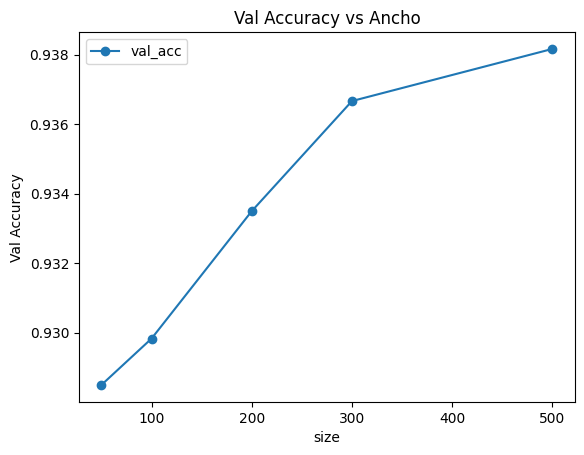

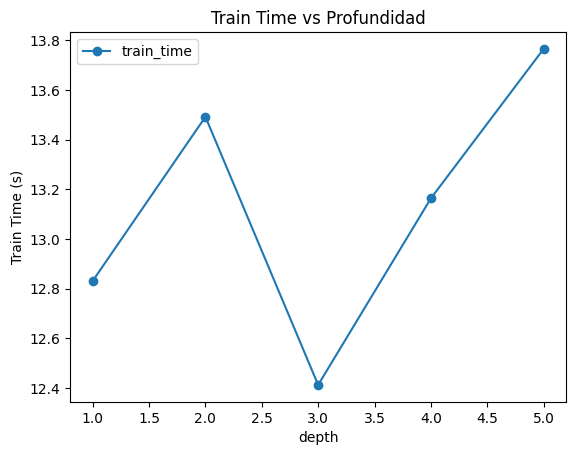

In [12]:
# Precisión vs Ancho (Ej1)
df1.plot(x='size', y='val_acc', marker='o', title='Val Accuracy vs Ancho')
plt.ylabel('Val Accuracy')
plt.show()

# Tiempo vs Profundidad (Ej3)
df3.plot(x='depth', y='train_time', marker='o', title='Train Time vs Profundidad')
plt.ylabel('Train Time (s)')
plt.show()

## Ejercicio 12: Modelo Óptimo (14 pts)

Objetivo: Con base en los experimentos, seleccionar configuración que alcance ≥98.5% de precisión.

In [13]:
opt_cfg = {'hidden_layers':[300,150],
           'activations':['relu','relu'],
           'learning_rate':0.005,
           'dropout_rate':0.3,
           'l2_reg':1e-4}
res_opt = run_experiment(opt_cfg, epochs=15)
print(f"Óptimo -> val_acc={res_opt['val_accuracy']:.4f}, time={res_opt['train_time']:.2f}s")

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Óptimo -> val_acc=0.9407, time=28.20s


Conclusión: Documenta por qué esta combinación brinda el mejor compromiso entre precisión y costo computacional.